In [1]:
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
import radio_beam
from spectral_cube import SpectralCube
from reproject import reproject_exact
import matplotlib.pyplot as plt

In [2]:
#path = '/export/data1/brodriguez/'
path = '/vol/aibn1081/data1/brodriguez/'

# Opening CO(2-1) data cube for UGC12250

In [3]:
CO_cube = SpectralCube.read(path+'UGC12250_7m_co21_pbcor.fits')

In [4]:
CO_cube.beam

Beam: BMAJ=9.4445867644524 arcsec BMIN=5.4209408945904 arcsec BPA=-35.71292199102 deg

In [5]:
CO_cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'VRAD'  
CRVAL : 343.8995616667  12.79027758333  7613756.253316  
CRPIX : 61.0  61.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.0004166666666667  0.0004166666666667  -5081.347213086  
NAXIS : 120  120  197

## Extracting the minimal valid subcube

In [6]:
CO_cube = CO_cube.minimal_subcube()

## Opening Pipe3D output file for UGC12250

In [7]:
hdu_list = fits.open(path+'UGC12250.Pipe3D.cube.fits')

In [8]:
hdu_list.info()

Filename: /vol/aibn1081/data1/brodriguez/UGC12250.Pipe3D.cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  ORG_HDR       1 PrimaryHDU     515   ()      
  1  SSP           1 ImageHDU       118   (160, 149, 21)   float64   
  2  SFH           1 ImageHDU      1608   (160, 149, 319)   float64   
  3  INDICES       1 ImageHDU        79   (160, 149, 70)   float64   
  4  ELINES        1 ImageHDU        68   (160, 149, 11)   float64   
  5  FLUX_ELINES    1 ImageHDU      1310   (160, 149, 432)   float64   
  6  FLUX_ELINES_LONG    1 ImageHDU      3134   (160, 149, 1040)   float64   
  7  GAIA_MASK     1 ImageHDU        10   (160, 149)   float64   
  8  SELECT_REG    1 ImageHDU        10   (160, 149)   int64   


In [76]:
#hdu_list[5].header

In [9]:
V_band   = hdu_list[1].data[0]
M_star   = hdu_list[1].data[19]
OIII5007 = hdu_list[5].data[26]
Hbeta    = hdu_list[5].data[28]
#NII5755  = hdu_list[5].data[39] # check if this is the correct [NII] line
NII6584  = hdu_list[5].data[46]
OI6300   = hdu_list[5].data[41]
Halpha   = hdu_list[5].data[45]
SII6717  = hdu_list[5].data[49]
region = hdu_list[8].data

In [10]:
frames = np.array([V_band,M_star,OIII5007,Hbeta,NII6584,OI6300,Halpha,SII6717])

In [11]:
for image in frames:
    image[region<1] = np.nan

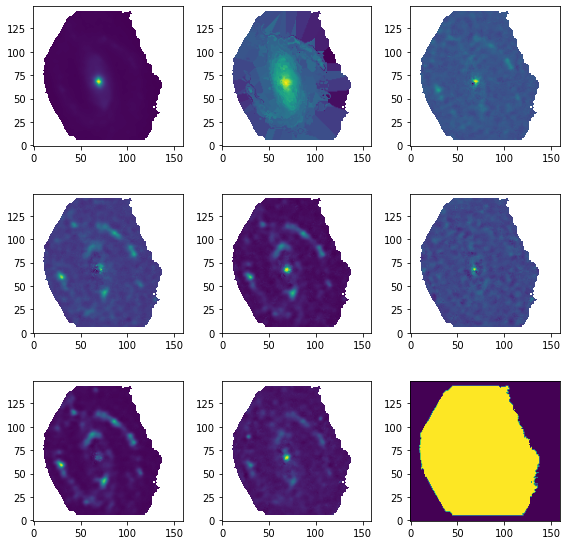

In [12]:
fig, axs = plt.subplots(3,3,figsize=(8,8))
for image, ax in zip(frames,axs.ravel()):
    ax.imshow(image,origin='lower')
axs[2,2].imshow(region,origin='lower')
fig.tight_layout()
plt.show()

In [13]:
wcs_califa = WCS(hdu_list[0].header).to_header()

In [14]:
#wcs_califa['CDELT1']=wcs_califa['PC1_1']
#wcs_califa['CDELT2']=wcs_califa['PC2_2']
#wcs_califa['PC1_1']=1.0
#wcs_califa['PC2_2']=1.0
#wcs_califa['NAXIS']=3
#wcs_califa['NAXIS1']=ssp[0].shape[1]
#wcs_califa['NAXIS2']=ssp[0].shape[0]
#wcs_califa['NAXIS3']=1
#wcs_califa['PC3_3']=1.
wcs_califa['CRPIX3']=0
wcs_califa['CTYPE3']='VRAD'
wcs_califa['CUNIT3']='m/s'
wcs_califa

WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 69.0 / Pixel coordinate of reference point            
CRPIX2  =                 63.0 / Pixel coordinate of reference point            
CRPIX3  =                    0 / Pixel coordinate of reference point            
PC1_1   = -0.00013888888888888 / Coordinate transformation matrix element       
PC2_2   =  0.00013888888888889 / Coordinate transformation matrix element       
PC3_3   =                  2.0 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT3  =                  1.0 / [Angstrom] Coordinate increment at reference po
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CUNIT3  = 'm/s     '        

In [15]:
frames_cube = SpectralCube(data=frames,wcs=WCS(wcs_califa))
frames_cube = frames_cube.with_mask(region)

In [16]:
beam_califa = radio_beam.Beam(major=2.5*u.arcsec, minor=2.5*u.arcsec, pa=0*u.deg)
beam_CO = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)

In [17]:
beam_list = radio_beam.Beams(beams=[CO_cube.beam,beam_califa])
common_beam = radio_beam.commonbeam.common_2beams(beam_list)
common_beam

Beam: BMAJ=9.4445867644524 arcsec BMIN=5.4209408945904 arcsec BPA=-35.71292199102 deg

In [18]:
frames_cube = frames_cube.with_beam(beam_califa)

In [19]:
frames_cube_convolved = frames_cube.convolve_to(beam_CO)

In [20]:
target_header = CO_cube.header

In [28]:
target_header['NAXIS3'] = None
target_header['CRPIX3'] = None
target_header['CDELT3'] = None
target_header['CUNIT3'] = None
target_header['CTYPE3'] = None
target_header['CRVAL3'] = None

In [22]:
target_header['NAXIS'] = 2
target_header['WCSAXES'] = 2

In [21]:
del target_header['NAXIS3'], target_header['CRPIX3'],target_header['CDELT3'],target_header['CUNIT3'],target_header['CTYPE3'],target_header['CRVAL3']

In [30]:
target_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2                                                  
NAXIS1  =                   74                                                  
NAXIS2  =                   72                                                  
NAXIS3  =                                                                       
BMAJ    =   2.623496323459E-03                                                  
BMIN    =   1.505816915164E-03                                                  
BPA     =  -3.571292199102E+01                                                  
BTYPE   = 'Intensity'                                                           
OBJECT  = 'UGC12250'                                                            
BUNIT   = 'beam-1 Jy'          / Brightness (pixel) unit                        
ALTRVAL =   2.246830823985E+

In [23]:
reprojected_list = []
for frame in frames_cube_convolved:
    reprojected, footprint = reproject_exact((frame,WCS(wcs_califa).celestial),target_header)
    reprojected_list.append(reprojected)
reprojected_list = np.array(reprojected_list)

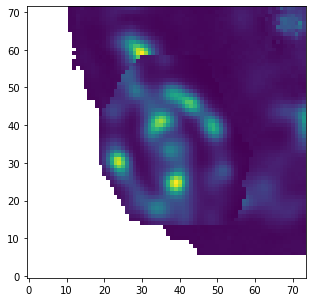

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(np.array(frames_cube[6,:,:]), origin='lower')
ax.imshow(reprojected_list[6],origin='lower')
plt.show()

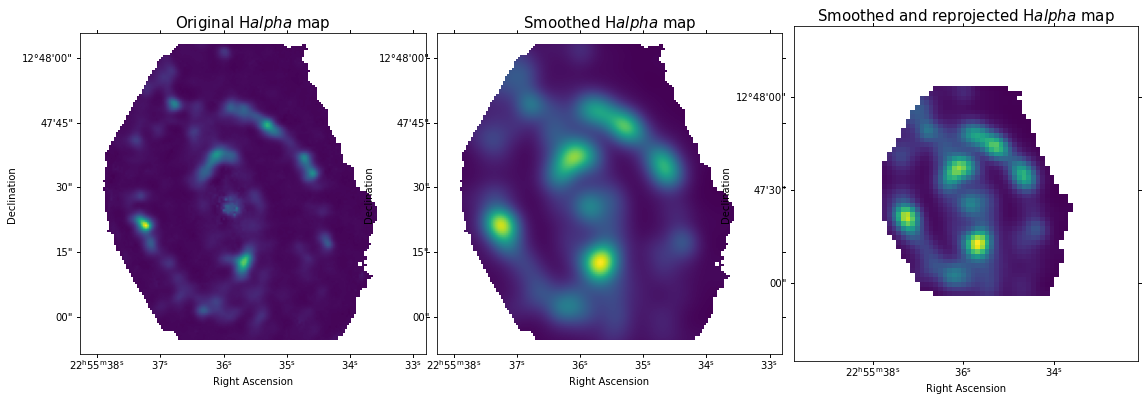

In [24]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1,projection=WCS(wcs_califa).celestial)
ax1.imshow(np.array(frames_cube[6,:,:]), origin='lower')
ax1.set_title('Original H$alpha$ map',fontsize=15)
ax2 = fig.add_subplot(1,3,2,projection=WCS(wcs_califa).celestial)
ax2.imshow(np.array(frames_cube_convolved[6,:,:]), origin='lower')
ax2.set_title('Smoothed H$alpha$ map',fontsize=15)
ax3 = fig.add_subplot(1,3,3,projection=WCS(target_header))
ax3.imshow(np.array(reprojected_list[6]), origin='lower')
ax3.set_title('Smoothed and reprojected H$alpha$ map',fontsize=15)
for ax in [ax1,ax2,ax3]:
    ax.coords['ra'].set_axislabel('Right Ascension')
    ax.coords['dec'].set_axislabel('Declination')
#ax2.coords['dec'].set_axislabel_position('r')
#ax2.coords['dec'].set_ticklabel_position('r')
fig.tight_layout()
plt.show()

In [ ]:
#V_band   = 0
#M_star   = 1
#OIII5007 = 2
#Hbeta    = 3
#NII6584  = 4
#OI6300   = 5
#Halpha   = 6
#SII6717  = 7

In [27]:
logratio_OIIIHbeta = np.log10(frames[2]/frames[3])
logratio_NIIHalpha = np.log10(frames[4]/frames[6])
logratio_SIIHalpha = np.log10(frames[7]/frames[6])
logratio_OIHalpha  = np.log10(frames[5]/frames[6])

logratio_rpj_OIIIHbeta = np.log10(reprojected_list[2]/reprojected_list[3])
logratio_rpj_NIIHalpha = np.log10(reprojected_list[4]/reprojected_list[6])
logratio_rpj_SIIHalpha = np.log10(reprojected_list[7]/reprojected_list[6])
logratio_rpj_OIHalpha  = np.log10(reprojected_list[5]/reprojected_list[6])

/tmp/ipykernel_507895/713731839.py:1: RuntimeWarning: invalid value encountered in log10
  logratio_OIIIHbeta = np.log10(frames[2]/frames[3])
/tmp/ipykernel_507895/713731839.py:2: RuntimeWarning: invalid value encountered in log10
  logratio_NIIHalpha = np.log10(frames[4]/frames[6])
/tmp/ipykernel_507895/713731839.py:3: RuntimeWarning: invalid value encountered in log10
  logratio_SIIHalpha = np.log10(frames[7]/frames[6])
/tmp/ipykernel_507895/713731839.py:4: RuntimeWarning: invalid value encountered in log10
  logratio_OIHalpha  = np.log10(frames[5]/frames[6])
/tmp/ipykernel_507895/713731839.py:6: RuntimeWarning: invalid value encountered in log10
  logratio_rpj_OIIIHbeta = np.log10(reprojected_list[2]/reprojected_list[3])
/tmp/ipykernel_507895/713731839.py:8: RuntimeWarning: invalid value encountered in log10
  logratio_rpj_SIIHalpha = np.log10(reprojected_list[7]/reprojected_list[6])
/tmp/ipykernel_507895/713731839.py:9: RuntimeWarning: invalid value encountered in log10
  logratio_

In [33]:
maskstar_NII = (0.61/(logratio_NIIHalpha-0.47)+1.19)>logratio_OIIIHbeta
maskagn_NII = (0.61/(logratio_NIIHalpha-0.47)+1.19)<=logratio_OIIIHbeta
maskstar_SII = (0.72/(logratio_SIIHalpha-0.32)+1.30)>logratio_OIIIHbeta
maskagn_SII = (0.72/(logratio_SIIHalpha-0.32)+1.30)<=logratio_OIIIHbeta
maskstar_OI  = (0.73/(logratio_OIHalpha +0.59)+1.33)>logratio_OIIIHbeta
maskagn_OI  = (0.73/(logratio_OIHalpha +0.59)+1.33)<=logratio_OIIIHbeta

maskstar_rpj_NII = (0.61/(logratio_rpj_NIIHalpha-0.47)+1.19)>logratio_rpj_OIIIHbeta
maskagn_rpj_NII = (0.61/(logratio_rpj_NIIHalpha-0.47)+1.19)<=logratio_rpj_OIIIHbeta
maskstar_rpj_SII = (0.72/(logratio_rpj_SIIHalpha-0.32)+1.30)>logratio_rpj_OIIIHbeta
maskagn_rpj_SII = (0.72/(logratio_rpj_SIIHalpha-0.32)+1.30)<=logratio_rpj_OIIIHbeta
maskstar_rpj_OI  = (0.73/(logratio_rpj_OIHalpha +0.59)+1.33)>logratio_rpj_OIIIHbeta
maskagn_rpj_OI  = (0.73/(logratio_rpj_OIHalpha +0.59)+1.33)<=logratio_rpj_OIIIHbeta

In [ ]:
#for image in frames:
#    image[region<1] = np.nan

In [29]:
xNII = np.linspace(-2,0.4,100)
yNII = 0.61/(xNII-0.47) + 1.19
xSII = np.linspace(-1.5,0.3,100)
ySII = 0.72/(xSII-0.32) + 1.3
xOI  = np.linspace(-2.5,-0.6,100)
yOI  = 0.73/(xOI+0.59) + 1.33

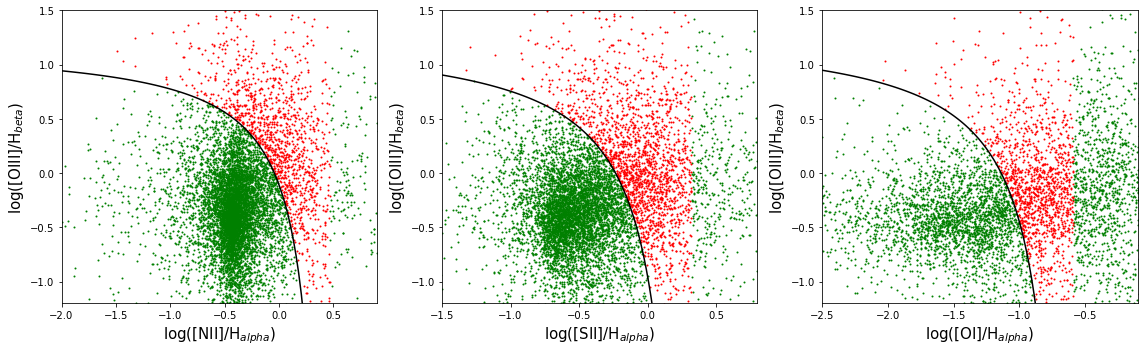

In [105]:
fig, axs = plt.subplots(1,3,figsize=(16,5))
for ax,ratio,maskstar,maskagn,x,y in zip(axs.ravel(),
                             [logratio_NIIHalpha,logratio_SIIHalpha,logratio_OIHalpha],
                             [maskstar_NII,maskstar_SII,maskstar_OI],[maskagn_NII,maskagn_SII,maskagn_OI],
                             [xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x,y,c='k')
    ax.scatter(ratio[mask],logratio_OIIIHbeta[mask],c='g',s=1.)
    ax.scatter(ratio[~mask],logratio_OIIIHbeta[~mask],c='r',s=1.)
    ax.set_ylabel('log([OIII]/H$_{beta}$)',fontsize=15)
    ax.set_xlim(x[0],x[-1]+0.5)
    ax.set_ylim(-1.2,1.5)
axs[0].set_xlabel('log([NII]/H$_{alpha}$)',fontsize=15)
axs[1].set_xlabel('log([SII]/H$_{alpha}$)',fontsize=15)
axs[2].set_xlabel('log([OI]/H$_{alpha}$)',fontsize=15)
fig.tight_layout()
plt.show()

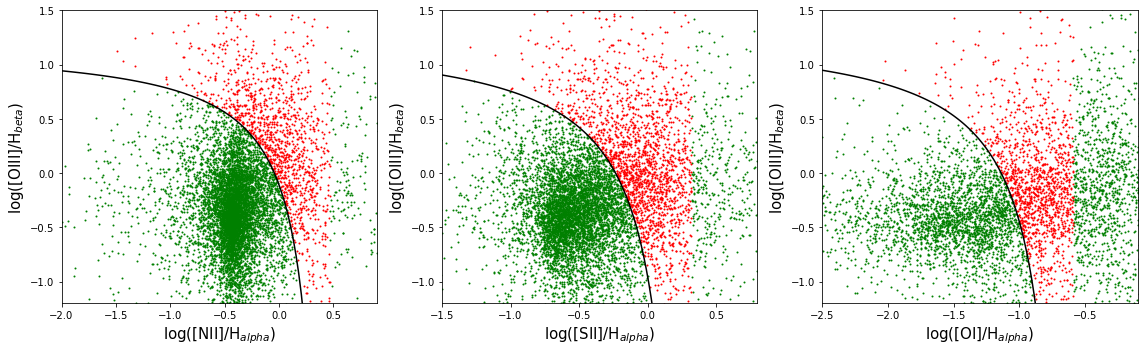

In [30]:
fig, axs = plt.subplots(1,3,figsize=(16,5))
for ax,ratio,maskstar,maskagn,x,y in zip(axs.ravel(),
                             [logratio_NIIHalpha,logratio_SIIHalpha,logratio_OIHalpha],
                             [maskstar_NII,maskstar_SII,maskstar_OI],[maskagn_NII,maskagn_SII,maskagn_OI],
                             [xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x,y,c='k')
    ax.scatter(ratio[maskstar],logratio_OIIIHbeta[maskstar],c='g',s=1.)
    ax.scatter(ratio[maskagn],logratio_OIIIHbeta[maskagn],c='r',s=1.)
    ax.set_ylabel('log([OIII]/H$_{beta}$)',fontsize=15)
    ax.set_xlim(x[0],x[-1]+0.5)
    ax.set_ylim(-1.2,1.5)
axs[0].set_xlabel('log([NII]/H$_{alpha}$)',fontsize=15)
axs[1].set_xlabel('log([SII]/H$_{alpha}$)',fontsize=15)
axs[2].set_xlabel('log([OI]/H$_{alpha}$)',fontsize=15)
fig.tight_layout()
plt.show()

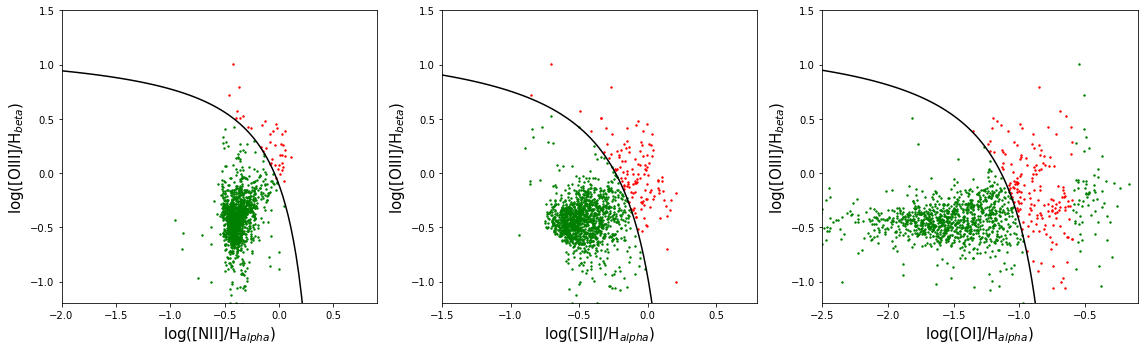

In [71]:
fig, axs = plt.subplots(1,3,figsize=(16,5))
for ax,ratio,maskstar,maskagn,x,y in zip(axs.ravel(),
                             [logratio_rpj_NIIHalpha,logratio_rpj_SIIHalpha,logratio_rpj_OIHalpha],
                             [mask_rpj_NII,mask_rpj_SII,mask_rpj_OI],[xNII,xSII,xOI],[yNII,ySII,yOI]):
    ax.plot(x,y,c='k')
    ax.scatter(ratio[mask],logratio_rpj_OIIIHbeta[mask],c='g',s=2.)
    ax.scatter(ratio[~mask],logratio_rpj_OIIIHbeta[~mask],c='r',s=2.)
    ax.set_ylabel('log([OIII]/H$_{beta}$)',fontsize=15)
    ax.set_xlim(x[0],x[-1]+0.5)
    ax.set_ylim(-1.2,1.5)
axs[0].set_xlabel('log([NII]/H$_{alpha}$)',fontsize=15)
axs[1].set_xlabel('log([SII]/H$_{alpha}$)',fontsize=15)
axs[2].set_xlabel('log([OI]/H$_{alpha}$)',fontsize=15)
fig.tight_layout()
plt.show()

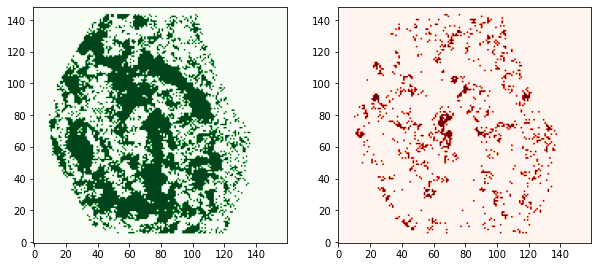

In [46]:
fig, ax =plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(maskstar_NII,origin='lower',cmap='Greens')
#ax[0].imshow(maskagn_NII,origin='lower',cmap='Reds')
ax[1].imshow(maskagn_NII,origin='lower',cmap='Reds')
plt.show()

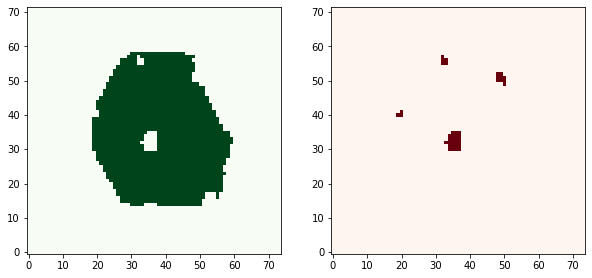

In [47]:
fig, ax =plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(maskstar_rpj_NII,origin='lower',cmap='Greens')
#ax[0].imshow(maskagn_NII,origin='lower',cmap='Reds')
ax[1].imshow(maskagn_rpj_NII,origin='lower',cmap='Reds')
plt.show()

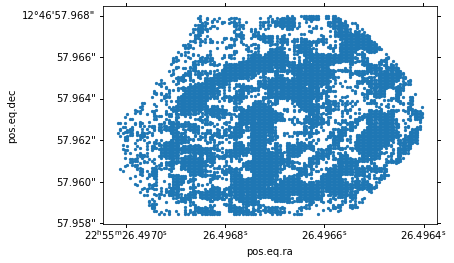

In [132]:
velo, dec, ra = frames_cube.world[0,:,:]
fig, ax = plt.subplots(subplot_kw={'projection':WCS(wcs_califa).celestial})
ax.scatter(ra.value[mask_NII],dec.value[mask_NII],s=5.)
plt.show()

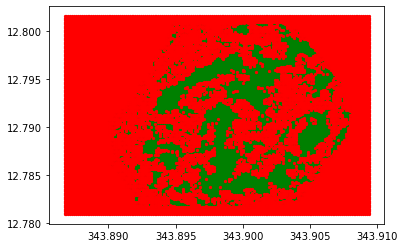

In [133]:
velo, dec, ra = frames_cube.world[0,:,:]
fig, ax = plt.subplots()
ax.scatter(ra.value[mask_NII],dec.value[mask_NII],c='g',s=5.)
ax.scatter(ra.value[~mask_NII],dec.value[~mask_NII],c='r',s=5.)
plt.show()

In [131]:
len(ratio_OIIIHbeta.flatten())

5328

In [135]:
np.count_nonzero(ratio_OIIIHbeta<0)

22

ratio=0 ->    0
ratio>0 ->  306
ratio<0 -> 1148
nan        3874
total      5328

ratio=0 ->    0
ratio>0 -> 1432
ratio<0 ->   22
nan        3874
total      5328